In [1]:
import glob
import csv
import pandas as pd

/home/jwei/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jwei/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Aggregate dev data (2015, 2016)

In [2]:
da = glob.glob('./dev/*/*/*.human.*')
print('\n'.join(da))

./dev/2015/DAseg-wmt-newstest2015/DAseg.newstest2015.human.en-ru
./dev/2015/DAseg-wmt-newstest2015/DAseg.newstest2015.human.fi-en
./dev/2015/DAseg-wmt-newstest2015/DAseg.newstest2015.human.cs-en
./dev/2015/DAseg-wmt-newstest2015/DAseg.newstest2015.human.de-en
./dev/2015/DAseg-wmt-newstest2015/DAseg.newstest2015.human.ru-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.tr-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.ru-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.cs-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.de-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.fi-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.ro-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.en-ru


In [3]:
cols = ['human', 'mt-system', 'reference', 'source']
data = { 'src':[], 'trg':[], 'set':[], 'source':[], 'reference':[], 'mt-system':[], 'human':[] }

for rating in da:
    attr = rating.split('.')
    lp = attr[-1]
    test_set = attr[-3]
    print('Processing %s, %s...' % (test_set, lp))
    
    length = len(list(open(rating, 'rt')))
    
    data['src'].extend(length * [lp[:2]])
    data['trg'].extend(length * [lp[3:]])
    data['set'].extend(length * [test_set])
    
    for col in cols:
        attr[-2] = col
        path = '.'.join(attr)
        
        data[col].extend([ i.strip() for i in open(path, 'rt') ])

Processing newstest2015, en-ru...
Processing newstest2015, fi-en...
Processing newstest2015, cs-en...
Processing newstest2015, de-en...
Processing newstest2015, ru-en...
Processing newstest2016, tr-en...
Processing newstest2016, ru-en...
Processing newstest2016, cs-en...
Processing newstest2016, de-en...
Processing newstest2016, fi-en...
Processing newstest2016, ro-en...
Processing newstest2016, en-ru...


In [4]:
dev = pd.DataFrame(data=data)
dev[['human']] = dev[['human']].apply(pd.to_numeric)
dev.head()

,src,trg,set,source,reference,mt-system,human
0,en,ru,newstest2015,"""It's not unexpected, but it is still infuriat...","""Это не обмануло наши ожидания, но все-таки пр...","""Это не неожиданное, но это все еще меня бесиш...",-0.404580
1,en,ru,newstest2015,We're excited to be answering this demand by l...,"Мы рады отреагировать на такой спрос, запустив...",Мы быть для того чтобы отвечать этому требован...,-0.923881
2,en,ru,newstest2015,The winning couple had played the game for twe...,Выигравшая пара играет уже двадцать лет и сооб...,Пара победила на игру за двадцать лет и сказал...,-0.305908
3,en,ru,newstest2015,"Previously, a similar vehicle scrappage progra...",Ранее в России уже действовала подобная програ...,Ранее подобная программа утилизации транспортн...,0.141536
4,en,ru,newstest2015,But now I can play computer games with shootin...,Но теперь я могу играть в компьютерные игры со...,Но теперь я могу играть в компьютерные игры со...,1.149710


### Dev data statistics

In [5]:
dev['trg'].value_counts().plot(kind='bar')

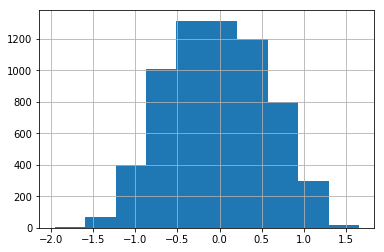

In [6]:
dev['human'].hist()

### Aggregate test data (2017)

In [7]:
da_seg = csv.reader(open('./wmt17-metrics-task-package/manual-evaluation/DA-seglevel.csv'), delimiter=' ')
headers = next(da_seg)

da_dict = {}
for row in da_seg:
    basename = '%s.%s.%s' % (row[1], row[2], row[0])
    line_num = int(row[3])
    da_dict[(basename, line_num)] = row[-1]

In [8]:
cols = ['human', 'mt-system', 'reference', 'source']
data = { 'src':[], 'trg':[], 'set':[], 'source':[], 'reference':[], 'mt-system':[], 'human':[] }

trials = glob.glob('./wmt17-metrics-task-package/input/tokenized/system-outputs/*/*/*')
for trial in trials:
    attr = trial.split('/')
    lp = attr[6].replace('-', '')
    refname = '%s-%s-ref.%s' % (attr[5], lp, lp[2:])
    srcname = '%s-%s-src.%s' % (attr[5], lp, lp[:2])
    
    basename = attr[-1]
    print('Processing %s...' % basename)
    try:
        source = list(open('./wmt17-metrics-task-package/input/raw/wmt17-submitted-data/txt/sources/%s' % srcname))
    except:
        source = list(open('./wmt17-metrics-task-package/input/raw/himltest17/txt/sources/%s' % srcname))
    reference = list(open('./wmt17-metrics-task-package/input/tokenized/references/%s' % refname))
    system_output = open(trial)
    
    for i, (src, ref, out) in enumerate(zip(source, reference, system_output), 1):
        if (basename, i) in da_dict:
            human = da_dict[(basename, i)]
            src, ref, out = src.strip(), ref.strip(), out.strip()
            
            data['src'].append(lp[:2])
            data['trg'].append(lp[2:])
            data['set'].append(attr[5])
            data['source'].append(src)
            data['reference'].append(ref)
            data['mt-system'].append(out)
            data['human'].append(human)

Processing himltest2017b.PBMT.en-ro...
Processing himltest2017b.Combo.en-ro...
Processing himltest2017a.Chimera.en-cs...
Processing himltest2017a.NMT.en-cs...
Processing himltest2017a.Tecto.en-cs...
Processing himltest2017a.Year1.en-pl...
Processing himltest2017a.PBMT.en-pl...
Processing himltest2017a.NMT.en-pl...
Processing himltest2017a.Combo.en-ro...
Processing himltest2017a.NMT.en-ro...
Processing himltest2017a.PBMT.en-ro...
Processing himltest2017a.Syntax.en-de...
Processing himltest2017a.PBMT.en-de...
Processing himltest2017a.NMT.en-de...
Processing newstest2017.tuning-task-denisov_4gb.sgm.0.en-cs...
Processing newstest2017.tuning-task-afrl_8gb.sgm.0.en-cs...
Processing newstest2017.tuning-task-ufal_4gb.sgm.0.en-cs...
Processing newstest2017.online-B.0.en-cs...
Processing newstest2017.LIUM-NMT.4947.en-cs...
Processing newstest2017.tuning-task-afrl_4gb.sgm.0.en-cs...
Processing newstest2017.CU-Chimera.4886.en-cs...
Processing newstest2017.LIUM-FNMT.4852.en-cs...
Processing newstes

### Test data (2017) statistics

In [9]:
test = pd.DataFrame(data=data)
test[['human']] = test[['human']].apply(pd.to_numeric)
test.head()

,src,trg,set,source,reference,mt-system,human
0,ru,en,newstest2017,В условиях санатория человек может проверить с...,"in the setting of a health resort , a person c...",in the conditions of sanatorium employees can ...,-0.612352
1,ru,en,newstest2017,"Так что не стоит бояться погоды за окном, тем ...","so , there &apos;s no need to fear the weather...","so do not be afraid of the weather outside , e...",0.651127
2,ru,en,newstest2017,"В июне показатель вырос на 1,7%.","in june , this figure rose by 1.7 % .",in june the indicator grew by 1.7 % .,0.540414
3,ru,en,newstest2017,"До этого она, кстати, успела выиграть серебро ...","prior to this , in fact , she managed to win s...","prior to that , she managed to win silver at t...",0.739021
4,ru,en,newstest2017,"Эмигрировав в США, она быстро вошла в юношеску...","having immigrated to the united states , she q...","emigrated to the us , she quickly entered in t...",-0.345920


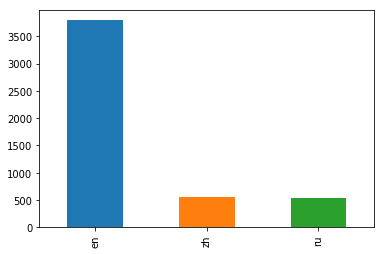

In [10]:
test['trg'].value_counts().plot(kind='bar')

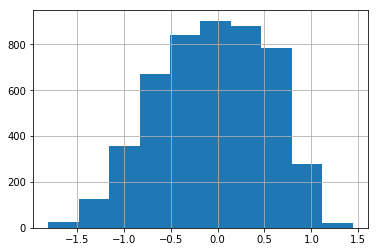

In [11]:
test['human'].hist()